<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><a href="https://www.kaggle.com/competitions/titanic/data">Titanic – L'apprentissage à partir d'une catastrophe</a></div>
     </th>
     <th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/titanic.jpg" width="96"></th>
 </tr>
<tr>                                                                                   
     <th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/titanic-naufrage.jpg" width="512"></th>
 </tr>    
</table>


<div style='padding:15px;color:#030aa7;font-size:100%;text-align: left;font-family: Georgia, serif'><a href="https://archive.ics.uci.edu/dataset/1/abalone">Veuillez vous référer à la page UC Irvine Machine Learning Repository officielle pour plus de détails.</a></div>





# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Introduction</div></b>
## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Import libriries </div></b>

In [1]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os, sys, time, copy as cp, pickle,re
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

import plotly.express as px
import plotly.graph_objects as go

In [2]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans


from matplotlib.colors import ListedColormap
from itertools import cycle
# from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler,MinMaxScaler,label_binarize
from sklearn.feature_extraction import DictVectorizer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeCV
from sklearn.svm import NuSVC, SVC, OneClassSVM
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel

from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier

from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                            precision_score, recall_score, f1_score, fbeta_score, jaccard_score, \
                            precision_recall_curve, average_precision_score, balanced_accuracy_score, \
                            classification_report, silhouette_score
from sklearn.metrics import roc_auc_score, zero_one_loss
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, \
                                    RepeatedStratifiedKFold, LeavePOut, LeaveOneGroupOut, \
                                    LeavePGroupsOut, ShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit, GridSearchCV

from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier

from sklearn.neighbors  import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble   import IsolationForest
from sklearn.svm        import OneClassSVM

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Outils du document</div></b>

In [3]:
sys.path.append(os.path.abspath('../../outils/'))
from prjFormation import palette

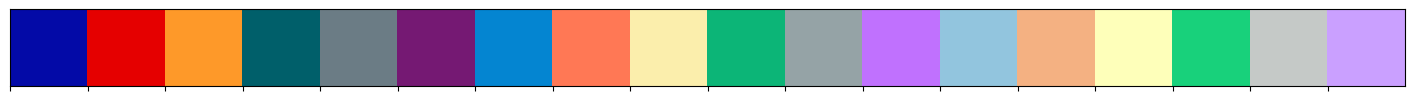

In [4]:
# palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
#             "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
#             "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
#           ]
sns.palplot(sns.color_palette(palette[:18]))

In [5]:
from prjFormation import initProjet,affichageDonnees2d,affichageDonnees3d,createLinkageMatrix, afficheDendrogram, affichageDistribution,afficheColonneCible, add_median_labels, formatPct

In [6]:
from classificationBinaires import initDictionnaireClassificateurs, confusion_matrix, \
                                   affichageEvolutionMetriques, affichageROC, executeValidationCroisee,afficheSeparationsBinaires, essaiApprentissageComparaisonClassificateurs

In [7]:
font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")
sns.set_style('darkgrid')
sns.set(font_scale=2)

In [8]:
projet = initProjet(repertoireRacine='.',nomProjet='Titanic-Classification')

In [9]:
def executionEssaiComparaisonClassificateurs( 
                       classificateursDict, 
                       X_train, 
                       y_train,
                       X_test, 
                       y_test, 
                       couleurs,
                       nom_essai,
                       projet, apprentissage = True):
    np.random.seed(123456)
    t0 = time.time()  
    # h = .02  # step size in the mesh
    lw = 1

    plt.figure(figsize=(36,18))

    r_acc,r_aucROC = dict(),dict()
    fauxPositifs, vraisPositifs, probabilites = dict(),dict(),dict()
    accuracy,logloss,hammingloss,precision,sensibilite,specificite,f1,jaccard = dict(),dict(),dict(),dict(),dict(),dict(),dict(),dict()
    prec, rec, tauxPR, avgPrecRec =  dict(),dict(),dict(),dict()
    vrais_negatifs, faux_positifs, faux_negatifs, vrais_positifs = dict(),dict(),dict(),dict()

    for i, nom in enumerate(sorted(classificateursDict.keys())):    
        t1 = time.time()  
        recapitulatif = f'{nom:21s} '
        #print(f'{nom:21s}',end=' ')
        if apprentissage : classificateursDict[nom].fit(X_train, y_train)

        y_probas = classificateursDict[nom].predict_proba(X_test)
        y_pred = classificateursDict[nom].predict(X_test)
        fauxPositifs[nom], vraisPositifs[nom], probabilites[nom] = roc_curve(y_test.ravel(), y_probas[:, 1])

        r_aucROC[nom]     = auc(fauxPositifs[nom], vraisPositifs[nom])
        accuracy[nom]     = accuracy_score(y_test,y_pred)
        logloss[nom]      = log_loss(y_test,y_pred)
        hammingloss[nom]  = hamming_loss(y_test,y_pred)
        precision[nom]    = precision_score(y_test,y_pred)
        sensibilite[nom]  = recall_score(y_test,y_pred)
        f1[nom]           = f1_score(y_test,y_pred)
        jaccard[nom]      = jaccard_score(y_test,y_pred)


        vrais_negatifs[nom]        = confusion_matrix(y_test, y_pred)[0, 0]
        faux_positifs[nom]         = confusion_matrix(y_test, y_pred)[0, 1]
        faux_negatifs[nom]         = confusion_matrix(y_test, y_pred)[1, 0]
        vrais_positifs[nom]        = confusion_matrix(y_test, y_pred)[1, 1]        

        specificite[nom]           = vrais_negatifs[nom]/(faux_positifs[nom]+vrais_negatifs[nom]) 

        prec[nom], rec[nom], tauxPR[nom] = precision_recall_curve(y_test.ravel(), y_probas[:, 1])
        avgPrecRec[nom] = average_precision_score(y_test.ravel(), y_probas[:, 1])

        # print(f'{nom:21s}'+(' %.4f' % accuracy[nom]).lstrip('0'),end='\t--\t')
        recapitulatif += (' %.4f' % accuracy[nom]).lstrip('0') + '\t--\t'
        recapitulatif += "Area under the ROC curve : %0.4f" % r_aucROC[nom] + '\t--\t'
        recapitulatif += 'Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0')
        
        #print((' %.4f' % accuracy[nom]).lstrip('0'),end='\t--\t')
        #print ("Area under the ROC curve : %0.4f" % r_aucROC[nom],end='\t--\t')
        #print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))
        print(recapitulatif)

        plt.subplot(1, 2, 1)
        plt.plot(fauxPositifs[nom], vraisPositifs[nom], color=couleurs[i], label=nom + '(AUC = %0.4f)' % r_aucROC[nom])

        plt.subplot(1, 2, 2)
        plt.step(rec[nom], prec[nom], where='post', color=couleurs[i], label=f"{nom}(AP = {avgPrecRec[nom]:0.8f})")#alpha=0.8, 
        plt.fill_between(rec[nom], prec[nom], step='post', alpha=0.05)



    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Le taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
    plt.ylabel('Le taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
    plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
    plt.legend(loc="lower right")    

    plt.subplot(1, 2, 2)
    f_scores = np.linspace(0.2, 0.9, num=7)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Sensibilité(Rappel) = VP / (VP + FN)', size=18)
    plt.ylabel('Précision = VP / (VP + FP)', size=18)      
    plt.title('La courbe Précision-Rappel',size=20)
    plt.legend(loc="lower left")    

    projet.sauvegarderImage(f"Les courbes ROC et Précision-Rappel--{nom_essai}")    
    plt.show()

    print('Exécution  :'+('%.2fs' % (time.time() - t0)).lstrip('0'))

    resultat = pd.DataFrame(pd.Series(r_aucROC), columns=["aucROC"])
    resultat['avgPrecRec']      = pd.Series(avgPrecRec   )
    resultat['accuracy']        = pd.Series(accuracy   )
    resultat['f1']              = pd.Series(f1         )
    resultat['precision']       = pd.Series(precision  )
    resultat['sensibilite']     = pd.Series(sensibilite)
    resultat['specificite']     = pd.Series(specificite)
    resultat['logloss']         = pd.Series(logloss    )
    resultat['hammingloss']     = pd.Series(hammingloss)
    resultat['jaccard']         = pd.Series(jaccard    )
    resultat["vrais_positifs"]  = pd.Series(vrais_positifs)
    resultat["vrais_negatifs"]  = pd.Series(vrais_negatifs)
    resultat["faux_positifs"]   = pd.Series(faux_positifs)
    resultat["faux_negatifs"]   = pd.Series(faux_negatifs)

    resultat['essai']           = nom_essai
    resultat                    = resultat.reset_index().rename(columns={'index':'Classifieur'}).set_index('Classifieur')
    
    resultat.sort_values('f1',ascending=False, inplace=True)
    return resultat


# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Démarche pour constituer un modèle de classification </div></b>

<img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/classification/demarche.png" width="800">

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Lecture des données</div></b>

<table>
    <tr> 
        <th  style="text-align:left">
            <table>
                <CAPTION style='padding:15px;color:#030aa7;font-size:150%;text-align: left;font-weight: bold;font-family: Georgia, serif'>
données d'entraînement (train.csv)<br>données de tests (test.csv)
</CAPTION>    
            <tr>                                                                                   
                <tr>                                                                                   
                     <th  style="text-align:left;background-color:#053061;color:white;">Colonne initiale </th>
                     <th  style="text-align:left;background-color:#053061;color:white;">Description</th>
                </tr>
                <tr>
                    <th  style="text-align:left;color:red;">survival</th>
                    <th  style="text-align:left;color:red;">Survie 0 = Non, 1 = Oui</th>
                </tr>
                <tr>
                    <th  style="text-align:left">pclass</th>
                    <th  style="text-align:left">Classe de billet 1 = 1er, 2 = 2e, 3 = 3e</th>
                </tr>
                <tr>
                    <th  style="text-align:left">name</th>
                    <th  style="text-align:left">Nom et titre du passager et les accompagnants</th>
                </tr>
                <tr>
                    <th  style="text-align:left">sex</th>
                    <th  style="text-align:left">Sexe</th>
                </tr>
                <tr>
                    <th  style="text-align:left">Age</th>
                    <th  style="text-align:left">Âge en années</th>
                </tr>
                <tr>
                    <th  style="text-align:left">sibsp</th>
                    <th  style="text-align:left">Nombre de frères et sœurs / conjoints à bord du Titanic</th>
                </tr>
                <tr>
                    <th  style="text-align:left">parch</th>
                    <th  style="text-align:left">Nombre de parents / enfants à bord du Titanic
ticket Numéro de billet</th>
                </tr>
                <tr>
                    <th  style="text-align:left">ticket</th>
                    <th  style="text-align:left">Numéro de billet</th>
                </tr>                
                <tr>
                    <th  style="text-align:left">fare</th>
                    <th  style="text-align:left">Tarif passager</th>
                </tr>
                <tr>
                    <th  style="text-align:left">cabin</th>
                    <th  style="text-align:left">Numéro de cabine</th>
                </tr>
                <tr>
                    <th  style="text-align:left">embarked</th>
                    <th  style="text-align:left">Port d'embarquement C = Cherbourg, Q = Queenstown, S = Southampton</th>
                </tr>
            </table>
        </th>
        <th  style="text-align:left"><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/titanic01.jpg" width="512"></th>
    </tr>
</table>

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Lecture des données</div></b>

<img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/classification/echantillonInitial.png" width="800">

In [10]:
donnees = pd.read_parquet(os.path.join(projet.repertoireDonnees, 'donneesClassification.parquet'), engine='pyarrow')
with open(os.path.join(projet.repertoireDonnees, 'variablesProjet.pickle'), 'rb') as fichier:
    dictConversions  = pickle.load(fichier)
    dictRConversions = pickle.load(fichier)
    varQualitatives  = pickle.load(fichier)
    varQuantatives   = pickle.load(fichier)
    cible            = pickle.load(fichier)

In [11]:
X = donnees.copy()
y = X.reset_index()[cible]
y.index = X.index

In [17]:
donnees.sample(5)

Classe  Sex   Age     Fare  Cabine  Pont  \
échantillon   PassengerId Survived                                             
apprentissage 816         Non            2    1  42.0   0.0000       1     1   
validation    915         Oui            2    1  21.0  61.3792       0     8   
test          632         Non            0    1  51.0   7.0542       0     8   
apprentissage 891         Non            0    1  32.0   7.7500       0     8   
              845         Non            0    1  17.0   8.6625       0     8   

                                    Port  Title  ConjointsOuFratrie  \
échantillon   PassengerId Survived                                    
apprentissage 816         Non          2      2                   0   
validation    915         Oui          0      2                   0   
test          632         Non          2      2                   0   
apprentissage 891         Non          1      2                   0   
              845         Non          2      2                   0   

                                    EnfantsOuParents  TailleFamille  \
échantillon   PassengerId Survived                                    
apprentissage 816         Non                      0              1   
validation    915         Oui                      1              2   
test          632         Non                      0              1   
apprentissage 891         Non                      0              1   
              845         Non                      0              1   

                                    TitreFamille  GroupFamilleFreq  \
échantillon   PassengerId Survived                                   
apprentissage 816         Non                  2                 0   
validation    915         Oui                  2                 2   
test          632         Non                  2                 0   
apprentissage 891         Non                  2                 0   
              845         Non                  2                 0   

                                    GroupFemmeEnfantFreq  \
échantillon   PassengerId Survived                         
apprentissage 816         Non                          0   
validation    915         Oui                          0   
test          632         Non                          0   
apprentissage 891         Non                          0   
              845         Non                          0   

                                    GroupFemmeEnfGouvFreq  
échantillon   PassengerId Survived                         
apprentissage 816         Non                           0  
validation    915         Oui                           0  
test          632         Non                           0  
apprentissage 891         Non                           0  
              845         Non                           0

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Separation des données pour l'apprentissage</div></b>

<img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/classification/echantillonTraitementValidation.png" width="800">

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Separation des données pour l'apprentissage</div></b>

<img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/classification/echantillonApprentissageTest.png" width="800">

In [12]:
X_train, X_test, y_train, y_test = X.loc[('apprentissage'),:],\
                                   X.loc[('test'),:],\
                                   y.loc[('apprentissage')].apply(lambda x: dictConversions[cible][x]),\
                                   y.loc[('test')].apply(lambda x: dictConversions[cible][x]) 

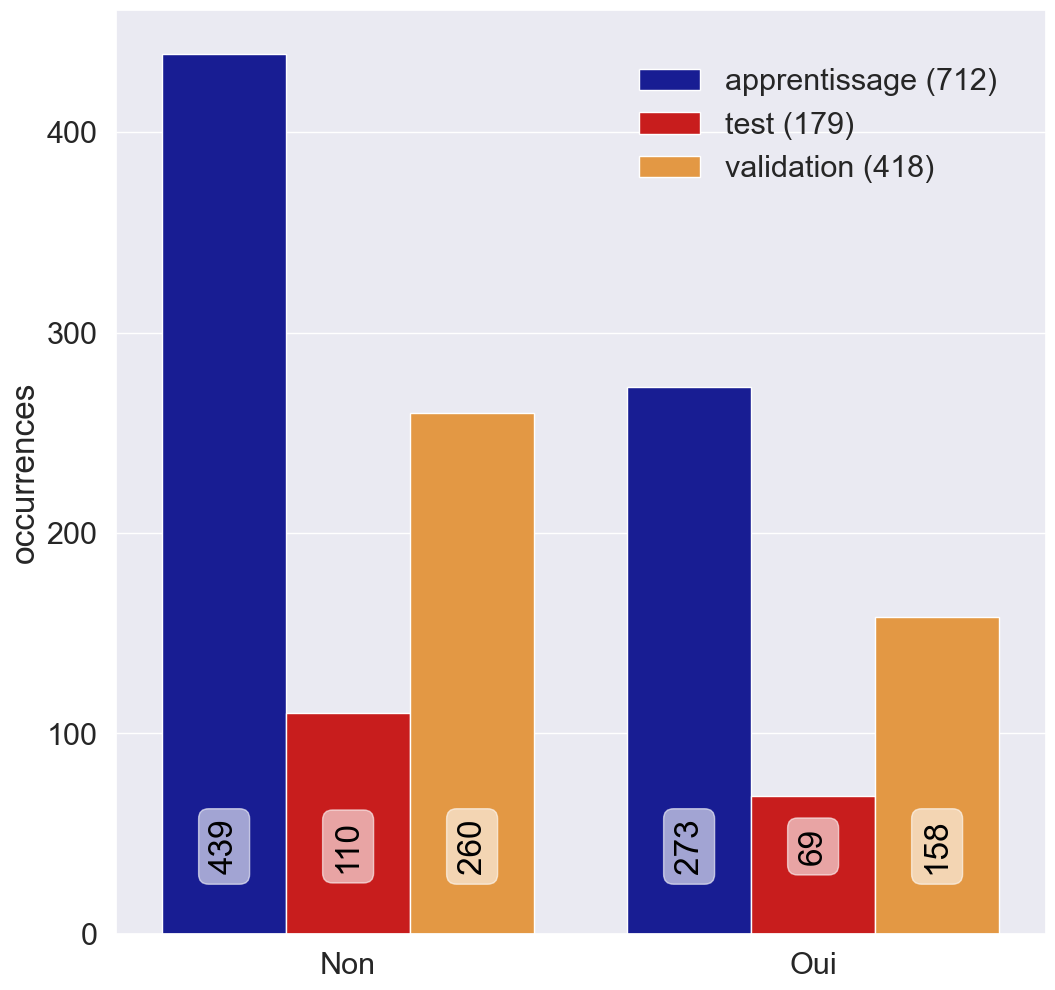

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
afficheSeparationsBinaires(donnees, palette, ax, cible='Survived')

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Déclaration des classificateurs </div></b>

In [14]:
classificateursDict =  initDictionnaireClassificateurs(arbres=12)
classificateursDict.pop('LightGBM'),\
classificateursDict.pop('XGBoost'),\
classificateursDict.pop('Stochastic_GD')

(LGBMClassifier(min_child_samples=10, min_split_gain=0.01, n_estimators=12,
                num_leaves=20, reg_alpha=0.1, reg_lambda=20),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='auc', feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=12, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 SGDClassifier(alpha=0.01, loss='log_loss', max_iter=200))

In [15]:
classificateursDict

{'Random_Forest': RandomForestClassifier(max_depth=6, max_features=3, min_samples_split=4,
                        n_estimators=12, n_jobs=-1),
 'AdaBoost': AdaBoostClassifier(n_estimators=12),
 'LogisticRegression': LogisticRegression(C=0.81113, max_iter=3000, n_jobs=-1),
 'Gaussian_Process': GaussianProcessClassifier(n_jobs=-1),
 'Nearest_Neighbors': KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=17, p=1,
                      weights='distance'),
 'Linear_SVM': SVC(C=10, kernel='linear', probability=True),
 'Radial_NuSVM': NuSVC(gamma=0.5, nu=0.195, probability=True),
 'Poly_NuSVM': NuSVC(kernel='poly', nu=0.1, probability=True),
 'GaussianNaiveBayes': GaussianNB(),
 'QuadraticDiscriminant': QuadraticDiscriminantAnalysis(),
 'Neural_Net': MLPClassifier(alpha=1)}

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Essai initial avec les donnes sans aucun traitement</div></b> 

AdaBoost               0.8045	--	Area under the ROC curve : 0.8248	--	Exécution  :.01s
GaussianNaiveBayes     0.7654	--	Area under the ROC curve : 0.8204	--	Exécution  :.01s
Gaussian_Process       0.7430	--	Area under the ROC curve : 0.7861	--	Exécution  :.02s
Linear_SVM             0.8045	--	Area under the ROC curve : 0.8341	--	Exécution  :.01s
LogisticRegression     0.7933	--	Area under the ROC curve : 0.8559	--	Exécution  :.01s
Nearest_Neighbors      0.7598	--	Area under the ROC curve : 0.8235	--	Exécution  :.07s
Neural_Net             0.7989	--	Area under the ROC curve : 0.8512	--	Exécution  :.01s
Poly_NuSVM             0.6816	--	Area under the ROC curve : 0.3800	--	Exécution  :.01s
QuadraticDiscriminant  0.7877	--	Area under the ROC curve : 0.8227	--	Exécution  :.01s
Radial_NuSVM           0.6480	--	Area under the ROC curve : 0.7729	--	Exécution  :.02s
Random_Forest          0.8101	--	Area under the ROC curve : 0.8558	--	Exécution  :.07s


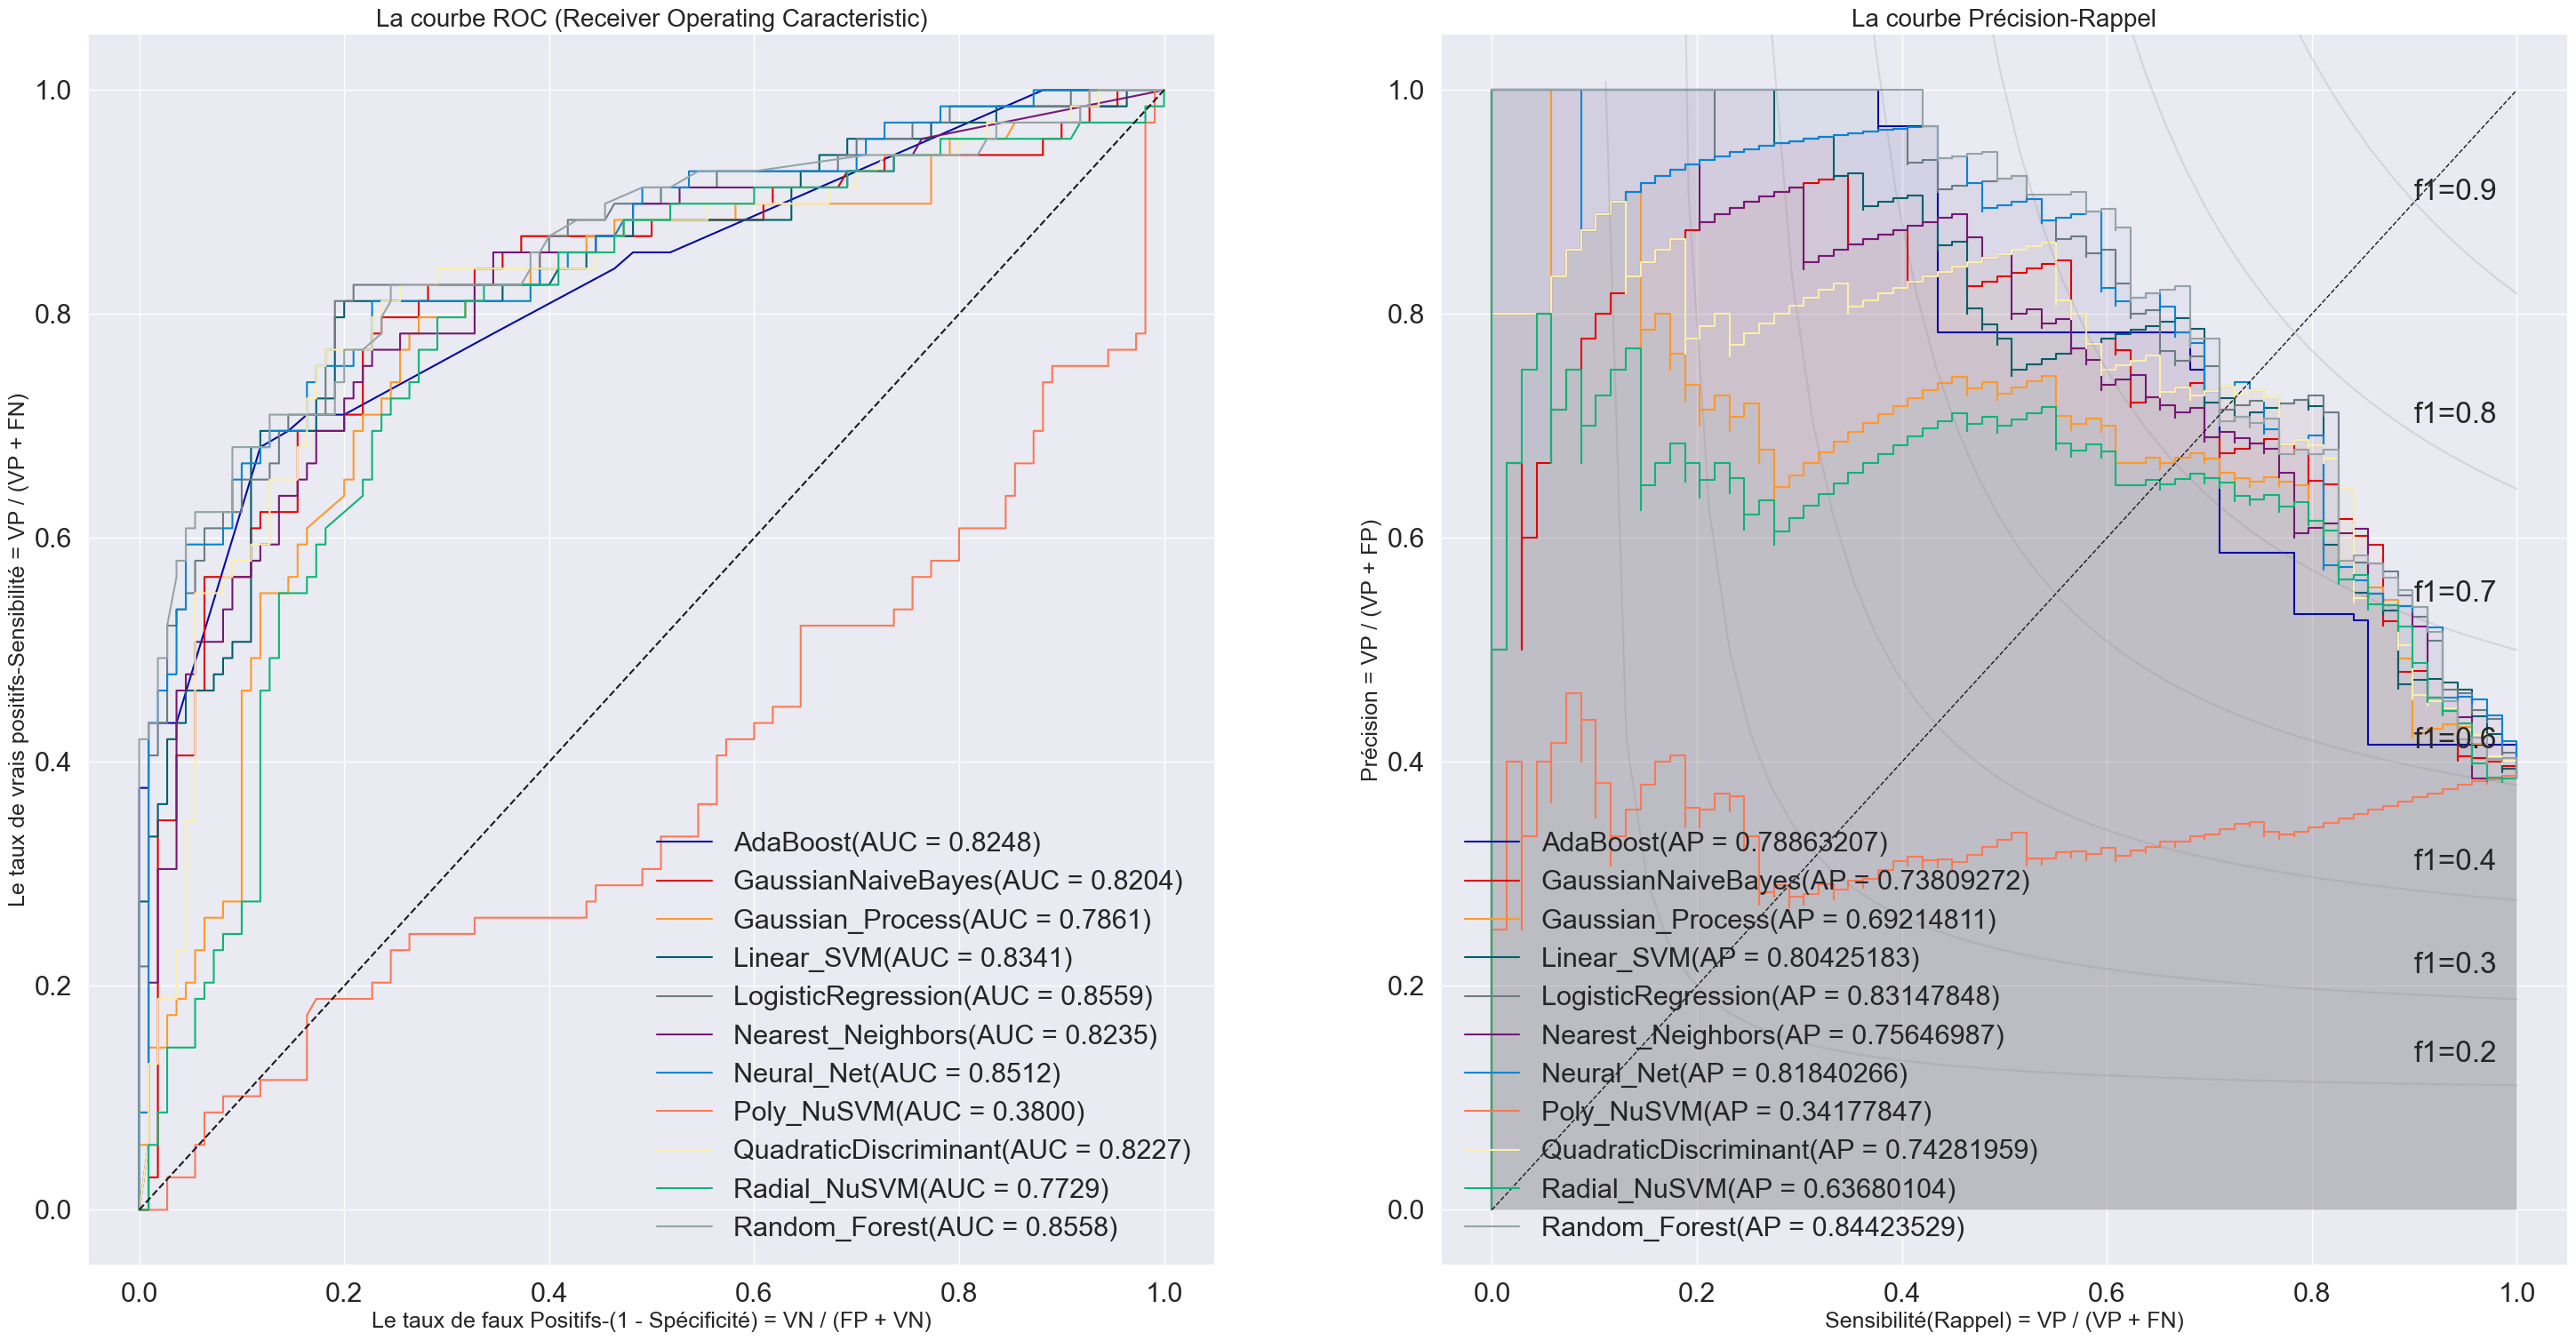

Exécution  :1.13s


In [19]:
resultats = executionEssaiComparaisonClassificateurs(classificateursDict, 
                                                     X_train, 
                                                     y_train,
                                                     X_test, 
                                                     y_test, 
                                                     couleurs = palette[:len(classificateursDict.keys())],
                                                     nom_essai = 'Initial', 
                                                     projet=projet, 
                                                     apprentissage=False)

In [ ]:
resultats.drop(columns=['vrais_positifs', 'vrais_negatifs',
                         'faux_positifs', 'faux_negatifs']).sort_values('aucROC',ascending=False).head(10)

,aucROC,avgPrecRec,accuracy,f1,precision,sensibilite,specificite,logloss,hammingloss,jaccard,essai
Classifieur,,,,,,,,,,,
LogisticRegression,0.855929,0.831478,0.793296,0.708661,0.775862,0.652174,0.881818,7.450364,0.206704,0.548780,Initial
Random_Forest,0.855797,0.844235,0.810056,0.742424,0.777778,0.710145,0.872727,6.846281,0.189944,0.590361,Initial
Neural_Net,0.851186,0.818403,0.798883,0.727273,0.761905,0.695652,0.863636,7.249003,0.201117,0.571429,Initial
Linear_SVM,0.834058,0.804252,0.804469,0.728682,0.783333,0.681159,0.881818,7.047642,0.195531,0.573171,Initial
AdaBoost,0.824769,0.788632,0.804469,0.728682,0.783333,0.681159,0.881818,7.047642,0.195531,0.573171,Initial
Nearest_Neighbors,0.823518,0.756470,0.759777,0.690647,0.685714,0.695652,0.800000,8.658531,0.240223,0.527473,Initial
QuadraticDiscriminant,0.822727,0.742820,0.787709,0.724638,0.724638,0.724638,0.827273,7.651725,0.212291,0.568182,Initial
GaussianNaiveBayes,0.820356,0.738093,0.765363,0.708333,0.680000,0.739130,0.781818,8.457170,0.234637,0.548387,Initial
Gaussian_Process,0.786100,0.692148,0.743017,0.651515,0.682540,0.623188,0.818182,9.262615,0.256983,0.483146,Initial
